In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
# import joblib
# import librosa
import random
from kapre import STFT, Magnitude, MagnitudeToDecibel, ApplyFilterbank
from tensorflow.keras.layers import Lambda
from tensorflow import reduce_min, reduce_max
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.layers import Conv2D, Dense, Dropout, GlobalAveragePooling2D, Input, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from timeit import default_timer as timer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
df = pd.read_csv('../dataset/imu_dataset.csv')
df

,subject,class,scenario,timestamp,accX,accY,accZ,gyrX,gyrY,gyrZ
0,subject1,normal,0,1733143133217,2.50347,0.92154,0.53716,-0.01380,0.01094,-0.00061
1,subject1,normal,0,1733143133267,2.91587,-0.10845,0.24650,-0.01153,0.00783,0.00070
2,subject1,normal,0,1733143133316,2.09685,0.23087,0.22614,-0.00326,-0.00018,0.00286
3,subject1,normal,0,1733143133368,3.55718,-1.27921,0.47487,0.00114,0.00148,0.00002
4,subject1,normal,0,1733143133417,4.75269,0.79279,-1.20326,-0.00456,0.00749,-0.00368
...,...,...,...,...,...,...,...,...,...,...
31355,subject1,minor_crash,210,1733918402058,46.09508,-5.42834,-34.29297,0.05467,-0.09112,0.04304
31356,subject1,minor_crash,210,1733918402105,-25.19053,11.36514,17.44765,0.01944,-0.09596,0.06311
31357,subject1,minor_crash,210,1733918402159,53.45271,-29.42361,-80.25206,0.02057,-0.00703,-0.09909
31358,subject1,minor_crash,210,1733918402209,-178.79508,49.69384,172.22260,-0.06077,-0.05234,-0.00718


In [3]:
print('Number of columns in the dataframe: %i' % (df.shape[1]))
print('Number of rows in the dataframe: %i\n' % (df.shape[0]))

Number of columns in the dataframe: 10
Number of rows in the dataframe: 31360



In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31360 entries, 0 to 31359
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   subject    31360 non-null  object 
 1   class      31360 non-null  object 
 2   scenario   31360 non-null  int64  
 3   timestamp  31360 non-null  int64  
 4   accX       31360 non-null  float64
 5   accY       31360 non-null  float64
 6   accZ       31360 non-null  float64
 7   gyrX       31360 non-null  float64
 8   gyrY       31360 non-null  float64
 9   gyrZ       31360 non-null  float64
dtypes: float64(6), int64(2), object(2)
memory usage: 2.4+ MB


In [5]:
df.describe()

,scenario,timestamp,accX,accY,accZ,gyrX,gyrY,gyrZ
count,31360.000000,3.136000e+04,31360.000000,31360.000000,31360.000000,31360.000000,31360.000000,31360.000000
mean,85.558036,1.733590e+12,-0.595469,-1.049940,-2.459397,0.010117,-0.008181,0.009863
std,64.413435,3.563225e+08,242.044748,153.432532,478.596020,0.267849,0.265273,0.657089
min,0.000000,1.733143e+12,-11816.310190,-9961.782770,-27984.889280,-8.997320,-4.819830,-21.060510
25%,24.000000,1.733161e+12,-3.637583,-2.827215,-2.566432,-0.019040,-0.021420,-0.017862
50%,77.000000,1.733839e+12,0.075390,-0.063020,0.001420,0.000020,-0.000040,0.000010
75%,142.000000,1.733903e+12,3.712333,2.309317,2.528955,0.019870,0.018240,0.021612
max,210.000000,1.733918e+12,8847.789770,8468.577300,18435.771400,6.089580,6.463000,14.051690


In [6]:
df.isnull().sum()

subject      0
class        0
scenario     0
timestamp    0
accX         0
accY         0
accZ         0
gyrX         0
gyrY         0
gyrZ         0
dtype: int64

In [7]:
df.duplicated().sum()

0

In [8]:
df['class'].unique()

array(['normal', 'severe_crash', 'minor_crash'], dtype=object)

In [9]:
df['class'].value_counts()

minor_crash     12660
severe_crash    12300
normal           6400
Name: class, dtype: int64

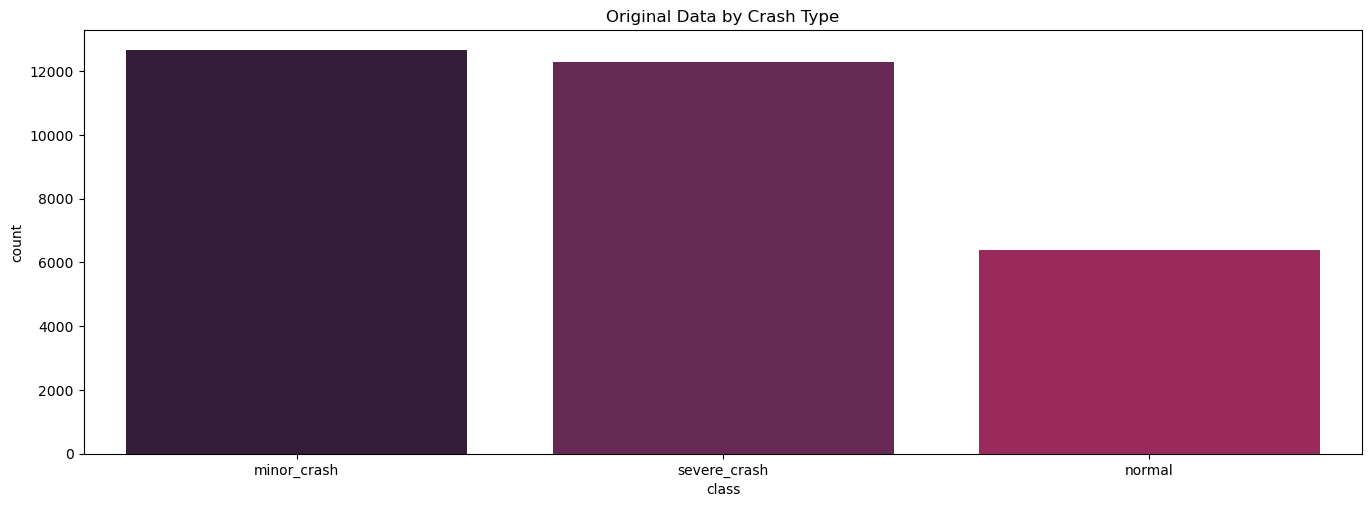

In [10]:
plt.figure(figsize=(16.5, 5.5))
plt.title('Original Data by Crash Type')
sns.countplot(data=df, x='class', order=df["class"].value_counts().index, palette = sns.color_palette("rocket"))
plt.show()

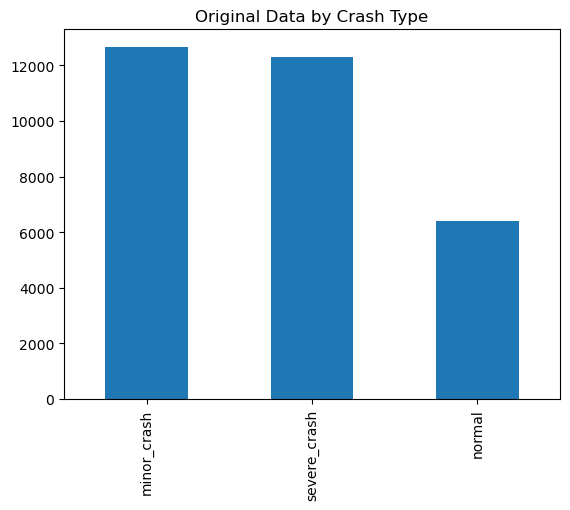

In [11]:
df['class'].value_counts().plot(kind='bar',
                                   title='Original Data by Crash Type')
plt.show()

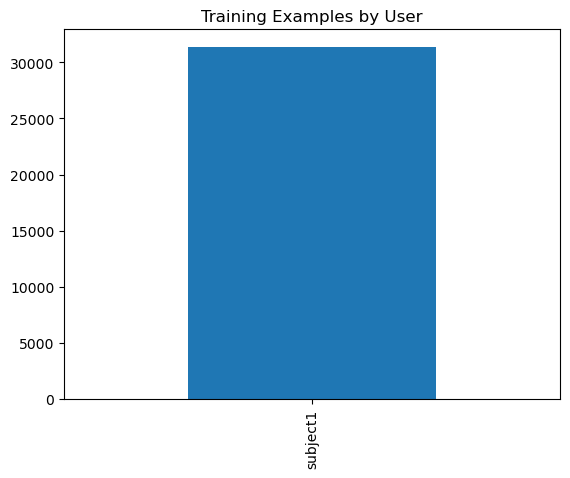

In [12]:
df['subject'].value_counts().plot(kind='bar',
                                  title='Training Examples by User')
plt.show()

In [13]:
print(f"Total subjects in the experiment: {len(set(df['subject']))}\n")
print(set(df['subject']))

Total subjects in the experiment: 1

{'subject1'}


<AxesSubplot:>

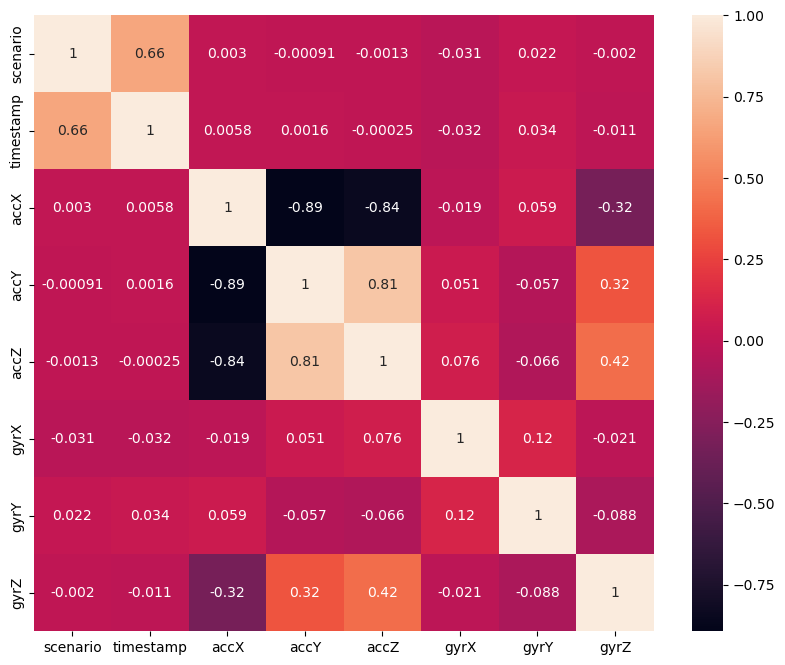

In [14]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True)

In [15]:
df['accX'] = df['accX'].astype('float')
df['accY'] = df['accY'].astype('float')
df['accZ'] = df['accZ'].astype('float')

df['gyrX'] = df['gyrX'].astype('float')
df['gyrY'] = df['gyrY'].astype('float')
df['gyrZ'] = df['gyrZ'].astype('float')

In [16]:
Fs = 20
activities = np.unique(df['class']) # or use: activities = data['class'].value_counts().index
activities

array(['minor_crash', 'normal', 'severe_crash'], dtype=object)

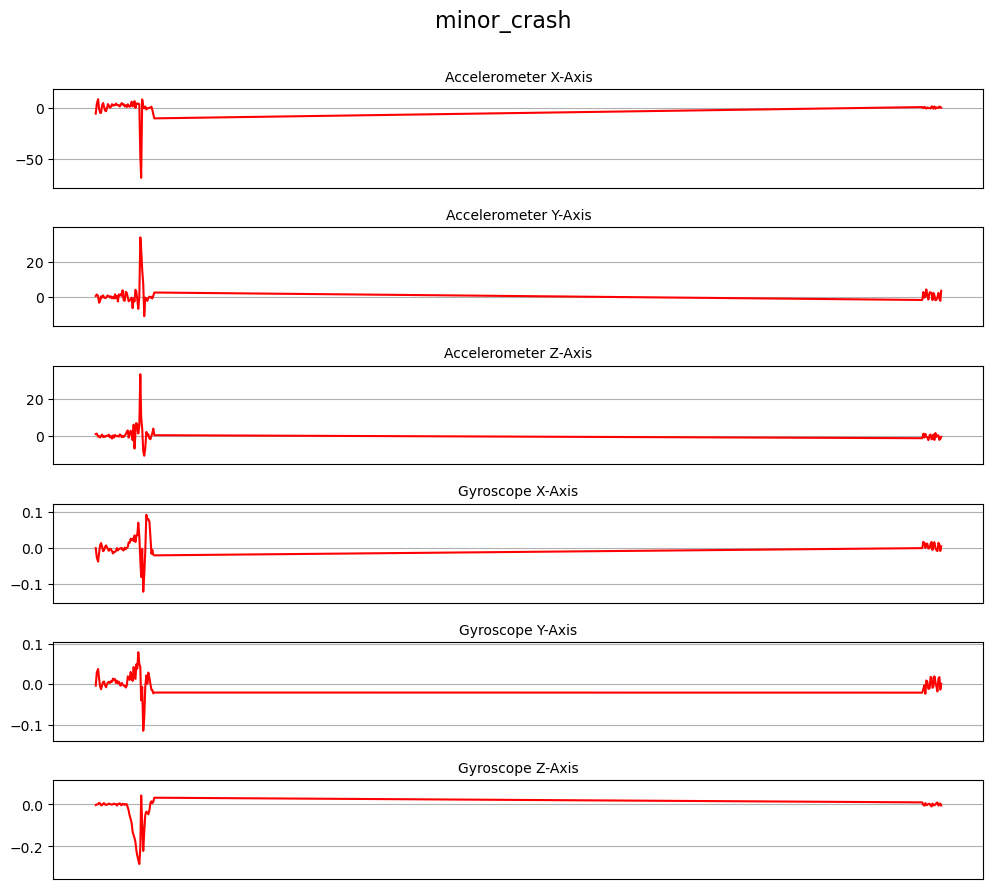

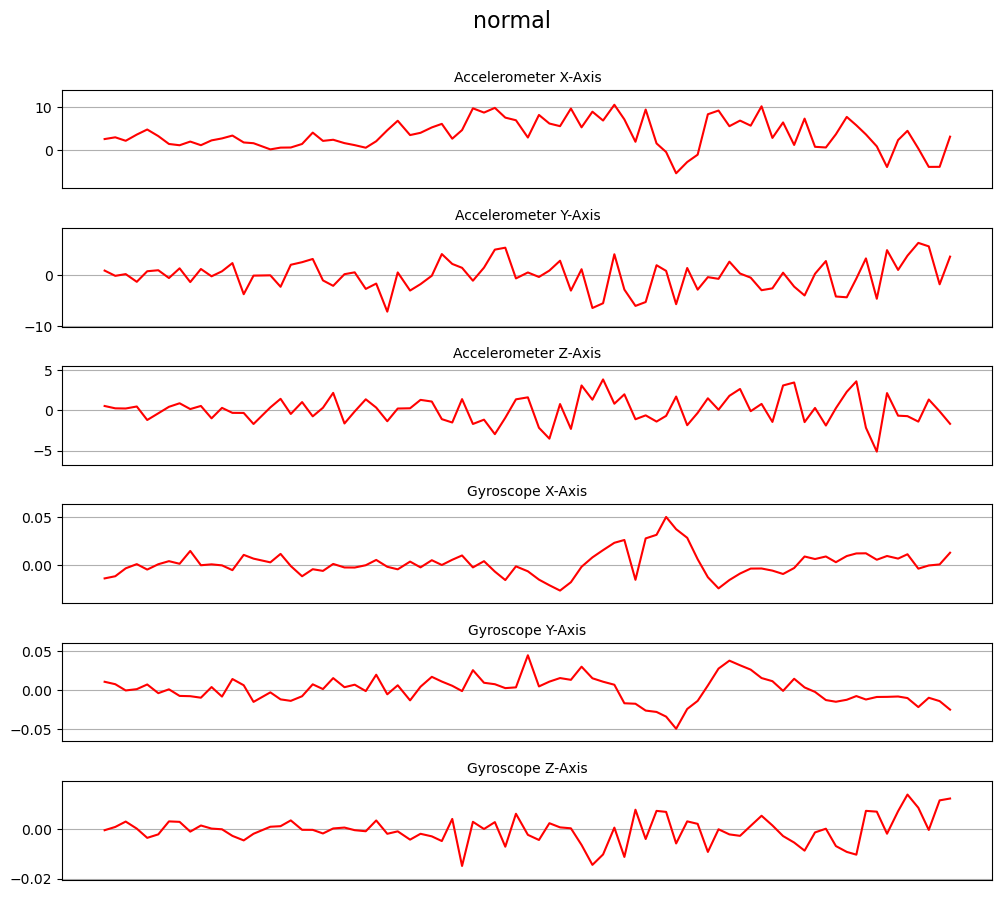

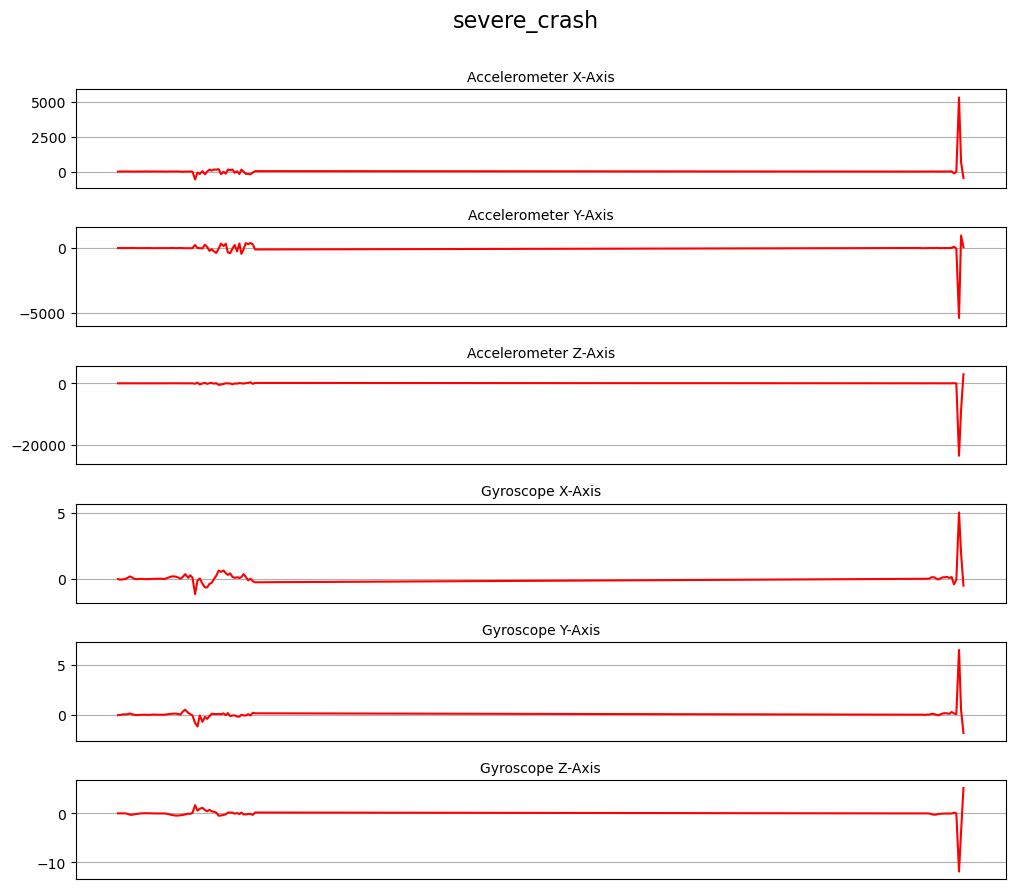

In [17]:
def plot_activity(activity, data):
    fig, axes = plt.subplots(nrows=6, figsize=(12, 10), sharex=True)
    
    # Plot accelerometer data
    plot_axis(axes[0], data['timestamp'], data['accX'], 'Accelerometer X-Axis')
    plot_axis(axes[1], data['timestamp'], data['accY'], 'Accelerometer Y-Axis')
    plot_axis(axes[2], data['timestamp'], data['accZ'], 'Accelerometer Z-Axis')
    
    # Plot gyroscope data
    plot_axis(axes[3], data['timestamp'], data['gyrX'], 'Gyroscope X-Axis')
    plot_axis(axes[4], data['timestamp'], data['gyrY'], 'Gyroscope Y-Axis')
    plot_axis(axes[5], data['timestamp'], data['gyrZ'], 'Gyroscope Z-Axis')
    
    # Adjust layout
    plt.subplots_adjust(hspace=0.4)
    fig.suptitle(activity, fontsize=16)
    plt.subplots_adjust(top=0.9)
    plt.show()

def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'r')
    ax.set_title(title, fontsize=10)
    ax.xaxis.set_visible(False)  # Hide x-axis labels for intermediate plots
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])  # Add buffer to y-axis range
    ax.grid(True)

# Loop through activities and plot
for activity in activities:
    data_for_plot = df[df['class'] == activity][:Fs*4]
    plot_activity(activity, data_for_plot)


In [18]:
label = LabelEncoder()
df['label'] = label.fit_transform(df['class'])
print(f"Types of classes: {label.classes_}\n")
df

Types of classes: ['minor_crash' 'normal' 'severe_crash']



,subject,class,scenario,timestamp,accX,accY,accZ,gyrX,gyrY,gyrZ,label
0,subject1,normal,0,1733143133217,2.50347,0.92154,0.53716,-0.01380,0.01094,-0.00061,1
1,subject1,normal,0,1733143133267,2.91587,-0.10845,0.24650,-0.01153,0.00783,0.00070,1
2,subject1,normal,0,1733143133316,2.09685,0.23087,0.22614,-0.00326,-0.00018,0.00286,1
3,subject1,normal,0,1733143133368,3.55718,-1.27921,0.47487,0.00114,0.00148,0.00002,1
4,subject1,normal,0,1733143133417,4.75269,0.79279,-1.20326,-0.00456,0.00749,-0.00368,1
...,...,...,...,...,...,...,...,...,...,...,...
31355,subject1,minor_crash,210,1733918402058,46.09508,-5.42834,-34.29297,0.05467,-0.09112,0.04304,0
31356,subject1,minor_crash,210,1733918402105,-25.19053,11.36514,17.44765,0.01944,-0.09596,0.06311,0
31357,subject1,minor_crash,210,1733918402159,53.45271,-29.42361,-80.25206,0.02057,-0.00703,-0.09909,0
31358,subject1,minor_crash,210,1733918402209,-178.79508,49.69384,172.22260,-0.06077,-0.05234,-0.00718,0


In [19]:
df['label'].value_counts()

0    12660
2    12300
1     6400
Name: label, dtype: int64

In [20]:
df = df.drop(['subject', 'class', 'timestamp'], axis=1)

In [21]:
# X_train = df.drop(['subject', 'class', 'scenario', 'timestamp', 'label'], axis=1)
# y_train = df['label']
# scenario_train = df['scenario']

In [22]:
# scaler=StandardScaler()
# X_train=scaler.fit_transform(X_train)
# joblib.dump(scaler, "scalerIMU_cnn1d_rawData.save")
# X_train[0]

In [23]:
# scaled_X = pd.DataFrame(data = X_train, columns = ['accX', 'accY', 'accZ', 'gyrX', 'gyrY', 'gyrZ'])
# scaled_X['label'] = y_train.values
# scaled_X['scenario'] = scenario_train.values

In [24]:
# # Sampling rate (Hz)
# Fs = 20

# # Frame size dan hop size berdasarkan sampling rate
# frame_size = Fs * 3  # 3 detik (60 sampel)
# hop_size = Fs * 1    # 1 detik overlap (20 sampel)

# for classes in df['label'].unique():
#     class_data = df[df['label'] == classes]
#     for scenario in class_data['scenario'].unique():
#         scenario_data = class_data[class_data['scenario'] == scenario]
#         for i in range(0, len(scenario_data) - frame_size + 1, hop_size):
#             segment = scenario_data.iloc[i: i + frame_size]
#             features = segment[['accX', 'accY', 'accZ', 'gyrX', 'gyrY', 'gyrZ']].values
#             transposed_frame = features.T
                
#                 # Flatten menjadi (1, 360)
#             flattened_frame = transposed_frame.reshape(1, -1)
#         # printflattened_frame
# print("FRAME:")
# print(np.array(features))
# print("\n\nTRANSPOSED:")
# print(transposed_frame)
# print("\n\nFLATTEN:")
# print(flattened_frame)

In [25]:
# Sampling rate (Hz)
Fs = 20

# Frame size dan hop size berdasarkan sampling rate
frame_size = Fs * 3  # 3 detik (60 sampel)
hop_size = Fs * 1    # 1 detik overlap (20 sampel)

# Fungsi untuk segmentasi berdasarkan skenario
def get_frames_by_scenario(df, frame_size, hop_size):
    N_FEATURES = 6  # accX, accY, accZ, gyrX, gyrY, gyrZ
    frames = []
    labels = []

    # Iterasi per skenario
    for classes in df['label'].unique():
        class_data = df[df['label'] == classes]
        for scenario in class_data['scenario'].unique():
            scenario_data = class_data[class_data['scenario'] == scenario]                
            for i in range(0, len(scenario_data) - frame_size + 1, hop_size):
                segment = scenario_data.iloc[i: i + frame_size]
                features = segment[['accX', 'accY', 'accZ', 'gyrX', 'gyrY', 'gyrZ']].values
                label = stats.mode(segment['label'])[0][0]
                frames.append(features)
                labels.append(label)
    
    # Merapikan format data
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)
    
    return frames, labels


In [26]:
def predict_and_visualize(frames, model, labels):
    # Pilih 9 sampel acak per kelas
    unique_labels = np.unique(labels)
    samples_per_class = {}
    for label in unique_labels:
        class_indices = np.where(labels == label)[0]
        random_samples = random.sample(list(class_indices), min(9, len(class_indices)))
        samples_per_class[label] = random_samples

    # Plot Mel-spectrogram dengan judul berdasarkan nama kelas
    fig, axes = plt.subplots(len(unique_labels), 9, figsize=(20, 10))
    class_names = ['Minor Crash', 'Normal', 'Severe Crash']

    for row, label_idx in enumerate(unique_labels):
        class_name = class_names[label_idx]  # Dapatkan nama kelas sesuai urutan
        for col, sample_idx in enumerate(samples_per_class[label_idx]):
            sample = frames[sample_idx]
            sample = sample[np.newaxis, :]
            
            # Prediksi dan generate Mel-spectrogram
            mel_spectrogram = model.predict(sample)  # (1, 128, T, 1)
            mel_spectrogram = mel_spectrogram[0, :, :, 0].T  # (128, T)

            ax = axes[row, col]
            ax.imshow(mel_spectrogram, aspect='auto', origin='lower', cmap='magma')
            # ax.axis('off')

            # Tambahkan judul pada kolom pertama setiap baris
            if col == 0:
                ax.set_ylabel(f"{class_name}", fontsize=14, labelpad=10)

    # Atur tampilan agar lebih rapi
    plt.subplots_adjust(hspace=0.5, wspace=0.1)  # Menambahkan jarak vertikal dan horizontal antar subplot
    plt.tight_layout(pad=2.0)  # Menambahkan padding di keseluruhan layout
    plt.show()
    return

In [27]:
# Membuat frame untuk data pelatihan dan pengujian
X_train_frames, y_train_frames = get_frames_by_scenario(df, frame_size, hop_size)
# X_test_frames, y_test_frames = get_frames_by_scenario(test, y_test, frame_size, hop_size)
X_train_frames.shape, y_train_frames.shape

((672, 60, 6), (672,))

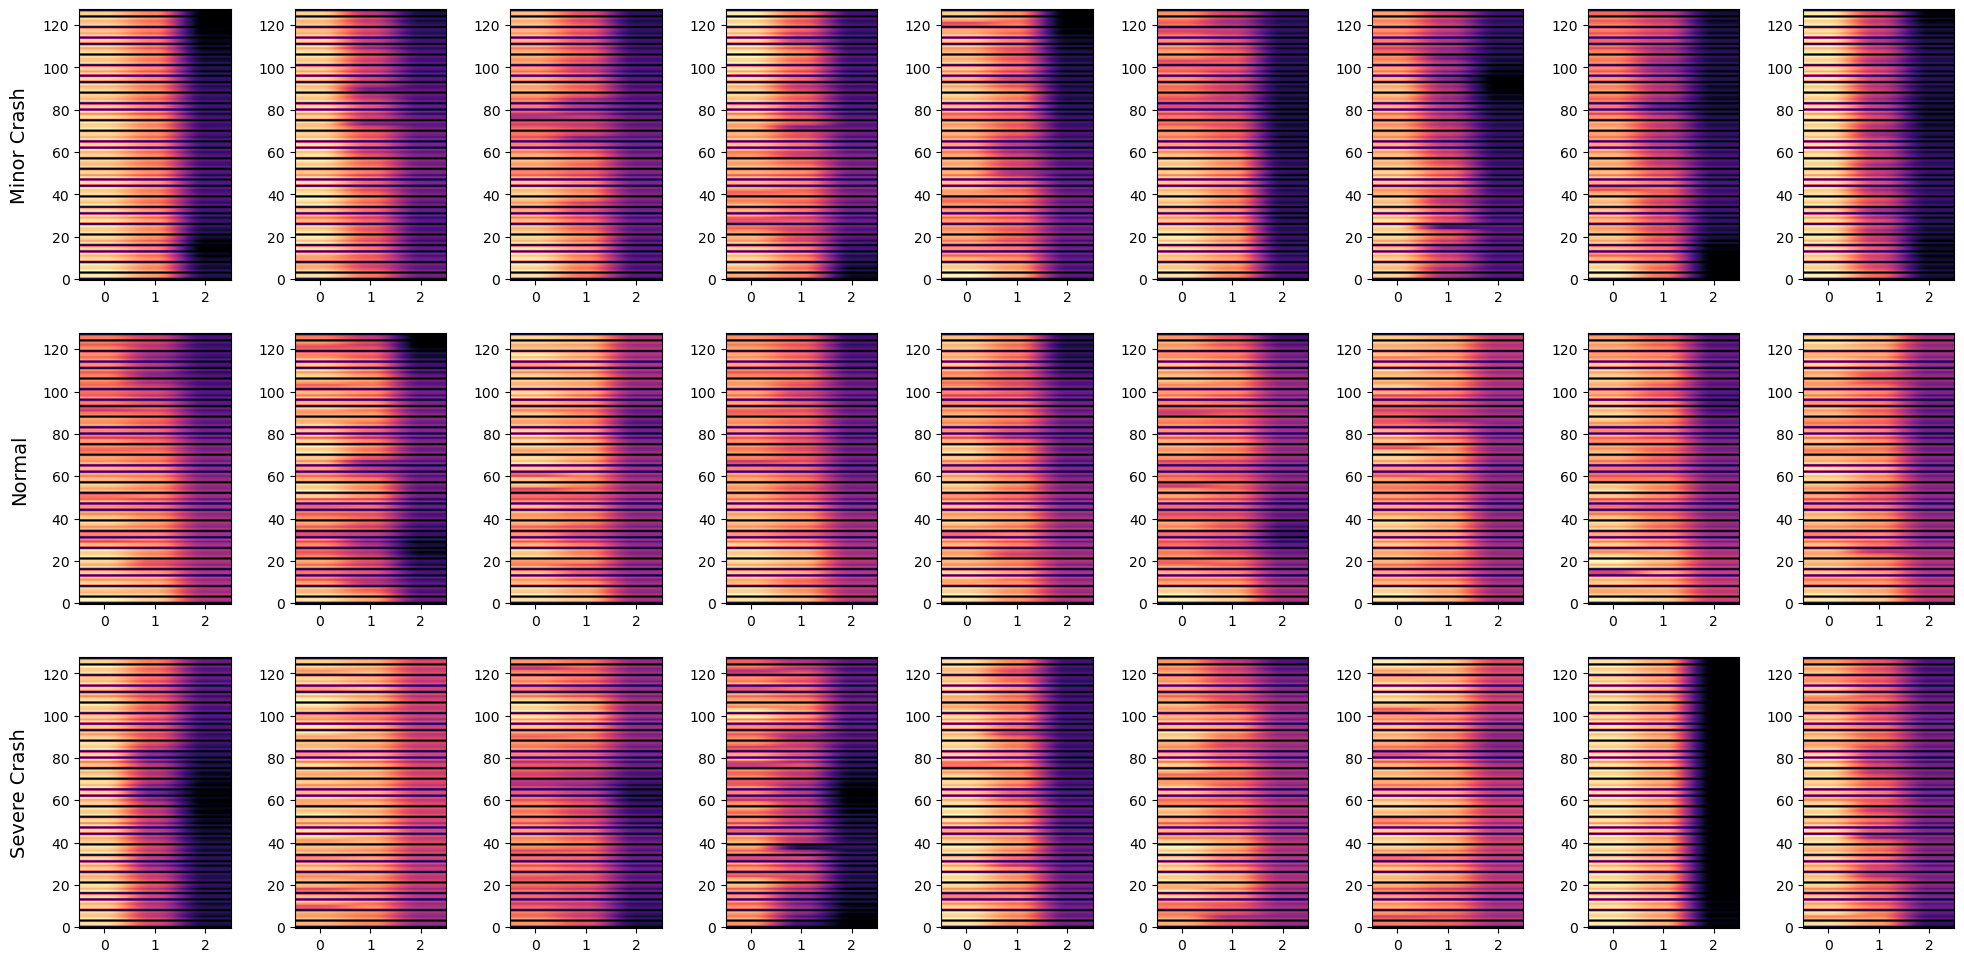

In [29]:
n_fft = 100
hop_length = n_fft//4
n_mels = 128

filterbank_kwargs = {
        'sample_rate': Fs,
        'n_freq': n_fft // 2 + 1,
        'n_mels': n_mels,
        'f_min': 0.0,
        'f_max': Fs // 2.0,
    }

model = Sequential([
    Input(shape=X_train_frames[0].shape),
    STFT(n_fft=n_fft, hop_length=hop_length, window_name='hann_window', pad_end=True),
    Magnitude(),
    Lambda(lambda x: x ** 2),
    ApplyFilterbank(type='mel', filterbank_kwargs=filterbank_kwargs),
    MagnitudeToDecibel()
])

predict_and_visualize(X_train_frames, model, y_train_frames)

In [30]:
class_counts = pd.Series(y_train_frames).value_counts()
print(class_counts)

1    256
0    211
2    205
dtype: int64


In [31]:
X_train, X_val, y_train, y_val = train_test_split(X_train_frames, y_train_frames, test_size=0.15, random_state=1337, stratify=y_train_frames)
X_train.shape, X_val.shape

((571, 60, 6), (101, 60, 6))

In [32]:
X_train[0].shape, X_val[0].shape

((60, 6), (60, 6))

In [33]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
# y_test_frames = to_categorical(y_test_frames)
y_train.shape, y_val.shape

((571, 3), (101, 3))

In [34]:
# Buat model Kapre
model = Sequential([
    Input(shape=X_train[0].shape),
    STFT(n_fft=n_fft, hop_length=hop_length, window_name='hann_window', pad_end=True),
    Magnitude(),
    Lambda(lambda x: x ** 2),
    ApplyFilterbank(type='mel', filterbank_kwargs=filterbank_kwargs),
    MagnitudeToDecibel(),
    # Lambda(lambda x: (x - reduce_min(x)) / (reduce_max(x) - reduce_min(x))), # Normalization between 0 - 1
    # Lambda(lambda x: 2 * ((x - reduce_min(x)) / (reduce_max(x) - reduce_min(x))) - 1), # Normalization between -1 - 1
    Conv2D(32, kernel_size=(1, 1), strides=(1, 1)),
    BatchNormalization(),
    LeakyReLU(alpha=0.05),
    Dropout(0.1),
    Conv2D(64, kernel_size=(1, 1), strides=(1, 1)),
    BatchNormalization(),
    LeakyReLU(alpha=0.05),
    Dropout(0.1), 
    GlobalAveragePooling2D(),
    Dense(256),
    BatchNormalization(),
    LeakyReLU(alpha=0.05),
    Dropout(0.3), 
    Dense(3, activation='softmax')


])
model.summary()


c:\Users\DELL\anaconda3\envs\tf230\lib\site-packages\librosa\util\decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
stft_2 (STFT)                (None, 3, 51, 6)          0         
_________________________________________________________________
magnitude_2 (Magnitude)      (None, 3, 51, 6)          0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 3, 51, 6)          0         
_________________________________________________________________
apply_filterbank_2 (ApplyFil (None, 3, 128, 6)         0         
_________________________________________________________________
magnitude_to_decibel_2 (Magn (None, 3, 128, 6)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 3, 128, 32)        224       
_________________________________________________________________
batch_normalization (BatchNo (None, 3, 128, 32)       

In [35]:
# model = Sequential([
#     Input(shape=X_train[0].shape),
#     Conv1D(128, kernel_size=3, strides=1),
#     LeakyReLU(alpha=0.05),
#     Dropout(0.1),
#     Conv1D(256, kernel_size=3, strides=1),
#     LeakyReLU(alpha=0.05),
#     Dropout(0.1),
    
#     GlobalAveragePooling1D(),
#     Dense(512),
#     LeakyReLU(alpha=0.05),
#     Dropout(0.3),
    
#     Dense(3, activation='softmax')
# ])

# model.summary()

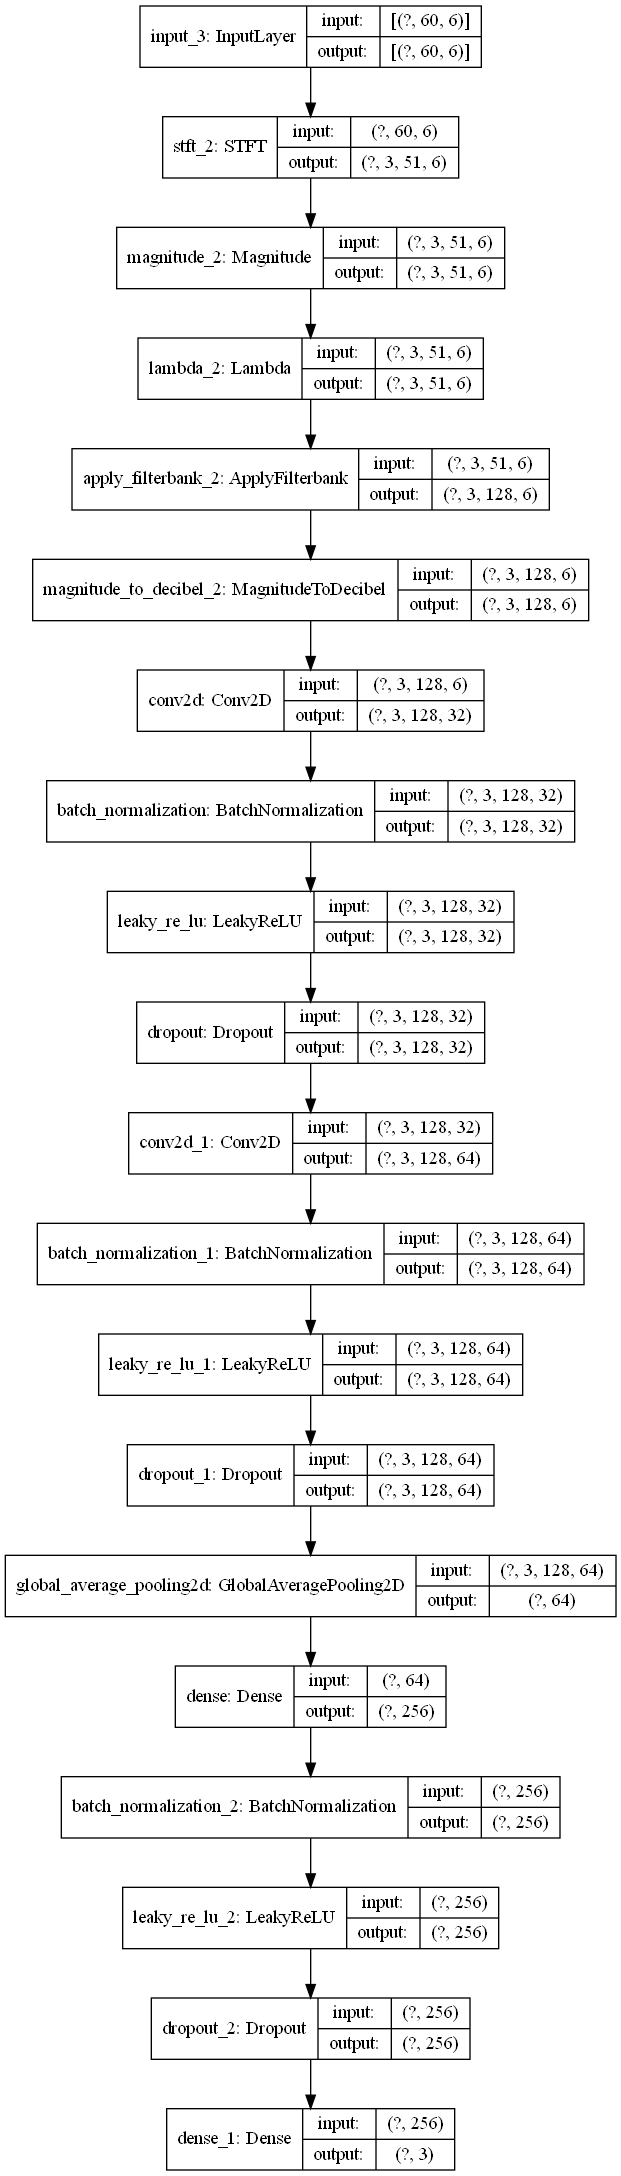

In [36]:
plot_model(model, show_shapes=True, to_file='architecture_model_cnn2d_melspectogram.png')

In [37]:
epochs = 100
lr=1e-4
batch_size = 32

class TimeCallback(Callback):
    def __init__(self):
        self.start_time = None
        self.epoch_time = 0.0
        self.total_time = 0.0
        self.iter_count = 0
    
    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = timer()
    
    def on_epoch_end(self, epoch, logs=None):
        self.epoch_time = timer() - self.start_time
        self.total_time += self.epoch_time
    
    def on_train_batch_end(self, batch, logs=None):
        self.iter_count += 1
    
    def on_train_end(self, logs=None):
        print("\nAverage iteration time: {:.2f} ms".format((self.total_time/self.iter_count) * 1000))
        print("Average epoch time: {:.2f} s".format(self.total_time/epochs))
        print("Total training time: {:.2f} s".format(self.total_time))

In [38]:
# Creating new directory to store the best model
os.makedirs("./model", exist_ok=True)

In [39]:
#Optimizer Adam
def get_optimizer():
    return Adam(learning_rate=lr)

#Compiling the model
model.compile(optimizer=get_optimizer(), loss='categorical_crossentropy', metrics=['accuracy'])
checkpoint = ModelCheckpoint("./model/model_imu_cnn2d_melspectogram.h5", verbose=1)
callback = TimeCallback()

In [40]:
hist = model.fit(X_train, 
                    y_train,
                    validation_data=(X_val, y_val),
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[callback, checkpoint])

Epoch 1/100
18/18 [==============================] - ETA: 0s - loss: 1.4095 - accuracy: 0.3187
Epoch 00001: saving model to ./model\model_imu_cnn2d_melspectogram.h5
18/18 [==============================] - 1s 64ms/step - loss: 1.4095 - accuracy: 0.3187 - val_loss: 1.0782 - val_accuracy: 0.5347
Epoch 2/100
17/18 [===========================>..] - ETA: 0s - loss: 0.9537 - accuracy: 0.5331
Epoch 00002: saving model to ./model\model_imu_cnn2d_melspectogram.h5
18/18 [==============================] - 1s 29ms/step - loss: 0.9426 - accuracy: 0.5394 - val_loss: 1.0496 - val_accuracy: 0.4752
Epoch 3/100
17/18 [===========================>..] - ETA: 0s - loss: 0.6927 - accuracy: 0.7114
Epoch 00003: saving model to ./model\model_imu_cnn2d_melspectogram.h5
18/18 [==============================] - 1s 34ms/step - loss: 0.7035 - accuracy: 0.7075 - val_loss: 1.0226 - val_accuracy: 0.4653
Epoch 4/100
14/18 [======================>.......] - ETA: 0s - loss: 0.6450 - accuracy: 0.7589
Epoch 00004: saving 

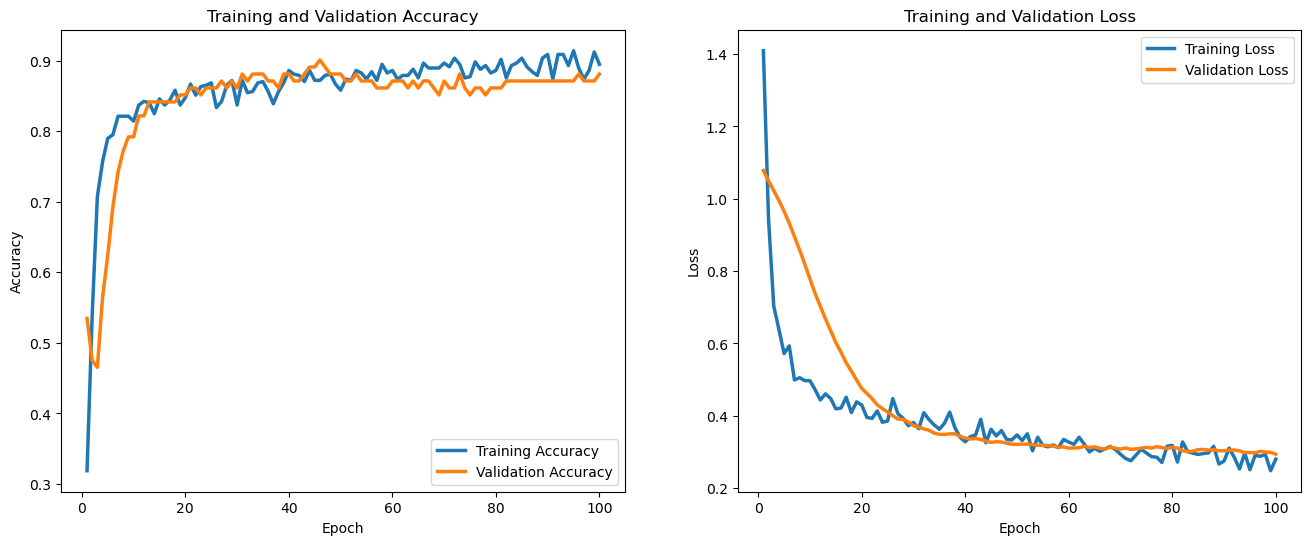

In [41]:
#Getting the accuracy
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

#Getting the losses
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plotting Training and Validation accuracy
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, '-', label='Training Accuracy', linewidth=2.5)
plt.plot(epochs, val_acc, '-', label='Validation Accuracy', linewidth=2.5)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, '-', label='Training Loss', linewidth=2.5)
plt.plot(epochs, val_loss, '-', label='Validation Loss', linewidth=2.5)
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [42]:
# Definisikan custom_objects untuk layer kustom Kapre
custom_objects = {
    'STFT': STFT,
    'Magnitude': Magnitude,
    'ApplyFilterbank': ApplyFilterbank,
    'MagnitudeToDecibel': MagnitudeToDecibel
}

# Memuat model dengan custom_objects
model = load_model('./model/model_imu_cnn2d_melspectogram.h5', custom_objects=custom_objects)
score_val = model.evaluate(X_val, y_val, verbose = 0) 
print('Val loss:', score_val[0]) 
print('Val accuracy:', score_val[1])

Val loss: 0.29394879937171936
Val accuracy: 0.8811880946159363


Text(74.30937500000006, 0.5, 'Actual label')

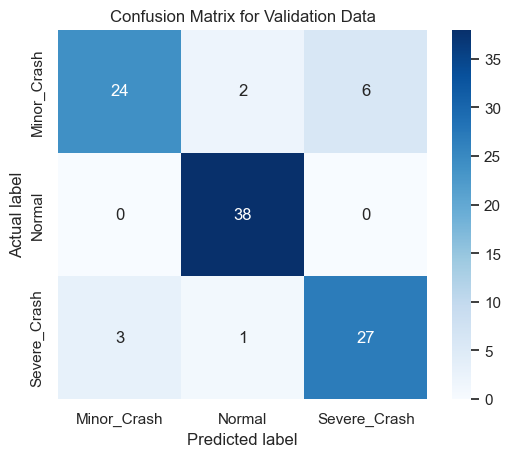

In [43]:
# Predict validation data
class_labels = ["Minor_Crash", "Normal", "Severe_Crash"]

sns.set()
val_predicted = model.predict(X_val)
y_val = y_val.argmax(axis=1)
y_val_predict = val_predicted.argmax(axis=1)
mat = confusion_matrix(y_val, y_val_predict)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=True, cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Confusion Matrix for Validation Data')
plt.xlabel('Predicted label')
plt.ylabel('Actual label')

In [44]:
print(classification_report(y_val, y_val_predict, target_names=class_labels))

              precision    recall  f1-score   support

 Minor_Crash       0.89      0.75      0.81        32
      Normal       0.93      1.00      0.96        38
Severe_Crash       0.82      0.87      0.84        31

    accuracy                           0.88       101
   macro avg       0.88      0.87      0.87       101
weighted avg       0.88      0.88      0.88       101

